In [1]:
!nvidia-smi -L


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9aae9ef5-0003-c313-917f-762d1f6f7977)


# Описание
Трудно сейчас это делать, но вот ноутбук для соревнования по классификации автомобиля по фотографии. 

# Выводы

Для наивной модели выбрал EffNetV2M (более подробнее в разделе по наивной модели). Далее хотел попробовать другие варианты, но модель дала хороший результат, поэтому остановился на ней.

Попробовал предсказания с и без TTA.

Таблица результатов (везде модель EffNetV2M, val size = 0.2):

| # | Head | TTA | Freeze | Epoch | Time | Test size | Val Acc | Kaggle | Note |
|:-:| ---- |:---:|:------:|:-----:|:----:|:---------:|:-------:|:------:| ---- |
| 1 | complex | N | N | 10 | ~2h fit | 12452 | 0.97941 | 0.97423 | нативная модель |
| 2 | simple | N | 0.5 | 10 | ~2h45m fit | 16000 | 0.9833 | 0.97872 | лучший результат |
| 3 | simple | Y | 0.5 | 10 | ~2h45m fit + 20m TTA | 16000 | 0.9833 | 0.97857 ||
| 4 | simple | N | N | 10 | ~3h10m fit | 16000 | 0.9790 | 0.97602 | уменьшал batch size, что бы в RAM влезть |
| 5 | simple | Y | N | 10 | ~3h10m fit + 20m TTA | 16000 | 0.9790 | 0.97662 ||
| 6 | simple | N | 1.0+0.5+0.25 | 10 | ~1h20m + 1h30m + 2h fit | 16000 | 0.98550 | 0.97677 | три этапа: полная заморозка, половина затем четверть слоев |
| 7 | simple | N | 0.5 | 15 | ~3h45m fit | 24000 | 0.99133 | 0.97498 | |

- в наивной модели использовал сложную голову на подобии примеров с платформы, как оказалось на следующей же модели этого можно и не делать, результат может быть даже лучше.
- варианты с и без заморозки дали примерно одинаковый результат.
- все результаты на актуальной (не старой) модели дали более 97% на kaggle, даже без особых заморочек с настройкой головы.
- всегда добавлял аугментацию, без нее даже не пробовал.
- сейчас понимаю, что некоторые вещи лучше в функции было бы вынести, но ждать такое количество часов на повторный прогон уже не хочу.
- лучший результат как по score, так и по времени дала модель с простой головой и заморозкой половины слоев. Я обясняю это так: актуальнные модели достаточно сильны "из коробки", поэтому не стоит без явной задачи делать сложную голову, а заморозка 50% слоев позвола сохранить уже обученные веса.
- \+ заморозки слоев еще и в том, что в RAM можно уместить больший batch size, что ускоряет время обучения (это и логично)
- судя по TTA есть "пограниичные" картинкии, которые прыгают из класса в класс, в зависимости от примененной аугментации, можно было бы посмотреть эти классы и попробовать достать для них больше картинок для тренировки.


# Загрузка данных

In [2]:
# подготавливаем данные
!gsutil cp gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip .
!unzip sf-dl-car-classification.zip
!unzip -q -o sf-dl-car-classification/train.zip
!unzip -q -o sf-dl-car-classification/test.zip

Copying gs://oleg-zyablov/skillfactory/sf-dl-car-classification.zip...
/ [1 files][  1.6 GiB/  1.6 GiB]   43.6 MiB/s                                   
Operation completed over 1 objects/1.6 GiB.                                      
Archive:  sf-dl-car-classification.zip
   creating: sf-dl-car-classification/
  inflating: sf-dl-car-classification/sample-submission.csv  
  inflating: sf-dl-car-classification/train.csv  
 extracting: sf-dl-car-classification/test.zip  
 extracting: sf-dl-car-classification/train.zip  


# Импорт библиотек

In [11]:
# добавим библиотеки
!pip install albumentations -U -q
!pip install "opencv-python-headless<4.3" -q

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os
import itertools

from pathlib import Path
import imageio

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# import efficientnet.tfkeras as efn
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from numba import cuda

import PIL
from PIL import ImageOps, ImageFilter
import albumentations as A


In [13]:
print("Python        :", sys.version.split("\n")[0])
print("Numpy         :", np.__version__)
print("Tensorflow    :", tf.__version__)
print("Keras         :", tf.keras.__version__)
print("albumentations:", A.__version__)

Python        : 3.7.12 (default, Jan 15 2022, 18:48:18) 
Numpy         : 1.21.5
Tensorflow    : 2.8.0
Keras         : 2.8.0
albumentations: 1.1.0


# Константы

In [22]:
# задание констант
EPOCHS = 10  # количество эпох
BATCH_SIZE = 32  # размер пакета для обучения
LR = 4e-4  # learning rate
VAL_SPLIT = 0.2  # размер валидиционной выборки
IMAGE_SIZE = (480, 480)  # размер рекомендуемый для сети картинки: высота х ширина
INPUT_SHAPE = (*IMAGE_SIZE, 3)  # параметры картинки: высота х ширина х число каналов
RANDOM_SEED = 42  # фиксирование зерна
MAX_IMAGE_COUNT = 2000 # число картинок для дополения тренировочного датасета

np.random.seed(RANDOM_SEED)
sample_submission_path = "/content/sf-dl-car-classification/sample-submission.csv"
train_path = "/content/train/"
sub_path = "/content/test_upload/"
drive_dir = "./drive/MyDrive/cars/"

# имена классов
class_names = [
    "Приора",  # 0
    "Ford Focus",  # 1
    "Самара",  # 2
    "ВАЗ-2110",  # 3
    "Жигули",  # 4
    "Нива",  # 5
    "Калина",  # 6
    "ВАЗ-2109",  # 7
    "Volkswagen Passat",  # 8
    "ВАЗ-21099",  # 9
]
class_ids = [x for x in range(len(class_names))]

# Подготовка

In [15]:
def show_first_images(
    generator,
    count=6,
    labels=True,
    figsize=(20, 5),
    normalized=False,
):
    """
    Display N images from image generator

    generator - image generator
    count=6 - number of images
    labes=True - add labes to (class num)
    figsize=(20, 5) - size of pict
    normalized=False - is image was nirmalized on not
    """
    generator = itertools.islice(generator, count)
    fig, axes = plt.subplots(nrows=1, ncols=count, figsize=figsize)
    for batch, ax in zip(generator, axes):
        if labels:
            img_batch, labels_batch = batch
            img, label = img_batch[0], np.argmax(labels_batch[0])
        else:
            img_batch = batch
            img = img_batch[0]
        if not normalized:
            img = img.astype(np.uint8)
        ax.imshow(img)
        if labels:
            ax.set_title(f"Class: {label}")
    plt.show()


# Аугментация для нативной модели
def native_augment(image):
    """
    Augmentation function
    """
    image = image.astype(np.uint8)
    transform = A.Compose(
        [
            A.HorizontalFlip(),
            A.GaussianBlur(p=0.2),
            A.RandomBrightnessContrast(p=0.3),
            A.ShiftScaleRotate(rotate_limit=20, p=0.4),
            A.OneOf(
                [
                    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
                    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
                ],
            ),
            A.HueSaturationValue(),
            A.RGBShift(),
            A.FancyPCA(),
            A.RandomCrop(int(IMAGE_SIZE[0]*0.8), int(IMAGE_SIZE[0]*0.8), p=0.4),
            A.Resize(*IMAGE_SIZE),
        ]
    )
    return transform(image=image)["image"]

# Аугментация для нативной модели
def model_augment(image):
    """
    Augmentation function
    """
    image = image.astype(np.uint8)
    transform = A.Compose(
        [
            A.HorizontalFlip(),
            A.GaussianBlur(p=0.2),
            A.RandomBrightnessContrast(p=0.3),
            A.ShiftScaleRotate(rotate_limit=20, p=0.4),
            A.OneOf(
                [
                    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
                    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
                ],
            ),
            A.HueSaturationValue(),
            A.RGBShift(),
            A.FancyPCA(),
            A.RandomCrop(int(IMAGE_SIZE[0]*0.8), int(IMAGE_SIZE[0]*0.8), p=0.4),
            A.CoarseDropout(max_holes=1, max_height=128, max_width=128),
            A.Resize(*IMAGE_SIZE),
        ]
    )
    return transform(image=image)["image"]

# Аугментация для TTA
def tta_augment(image):
    """
    Augmentation function
    """
    image = image.astype(np.uint8)
    transform = A.Compose(
        [
            A.HorizontalFlip(),
            A.ShiftScaleRotate(rotate_limit=20),
            A.RandomCrop(int(IMAGE_SIZE[0]*0.8), int(IMAGE_SIZE[0]*0.8)),
            A.Resize(*IMAGE_SIZE),
        ]
    )
    return transform(image=image)["image"]

def delete_augmented_image(root_folder, class_id):
    image_folder = Path.joinpath(Path(root_folder), str(class_id))
    image_list = Path(image_folder).glob("aug_*")
    del_cnt = 0
    for image in image_list:
        image.unlink()
        del_cnt += 1
    return del_cnt


def add_augmented_image(root_folder, class_id, image_count):
    def new_augment(image):
        image = image.astype(np.uint8)
        transform = A.Compose(
            [
                A.HorizontalFlip(always_apply=True),
                A.ShiftScaleRotate(rotate_limit=20, always_apply=True),
                A.ColorJitter(always_apply=True),
                A.Perspective(always_apply=True),
            ]
        )
        return transform(image=image)["image"]

    image_folder = Path.joinpath(Path(root_folder), str(class_id))
    image_path = Path(image_folder).glob("**/*")
    image_list = [name for name in image_path if name.is_file()]
    if image_count < len(image_list):
        return len(image_list), 0
    image_to_aug = np.random.choice(image_list, size=image_count - len(image_list), replace=False)
    datagen = ImageDataGenerator(preprocessing_function=new_augment)
    for image_file in image_to_aug:
        image = imageio.imread(image_file)
        if len(image.shape) == 2:
            image = np.expand_dims(image, 2)
        image = np.expand_dims(image, 0)
        datagen.fit(image)
        image_genertor = datagen.flow(
            image,
            save_to_dir=image_folder,
            save_prefix=f"aug_{np.random.randint(1000):04}",
            save_format="jpg",
        )
        _ = next(image_genertor)
    return len(image_list), len(image_to_aug)

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.style.use("ggplot")
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    epochs = range(len(acc))

    plt.plot(epochs, acc, "b", label="Training acc")
    plt.plot(epochs, val_acc, "g", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.show()

def add_tta(model, batch_size=BATCH_SIZE, cycles=11):
    sub_datagen_tta = ImageDataGenerator(
        preprocessing_function=tta_augment,
    )
    sub_generator_tta = sub_datagen_tta.flow_from_dataframe(
        dataframe=pd.read_csv(sample_submission_path),
        directory=sub_path,
        x_col="Id",
        y_col=None,
        class_mode=None,
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        shuffle=False,
    )

    show_first_images(sub_generator_tta, labels=False)
    sub_generator_tta.reset()
    show_first_images(sub_generator_tta, labels=False)  
    
    predictions = []
    for _ in range(cycles):
      predictions.append(model.predict(sub_generator_tta, verbose=1))
      sub_generator_tta.reset()
    predictions = np.array(predictions)

    plt.figure(figsize=(20, 5))
    plt.imshow(predictions.argmax(axis=-1)[:, 500:600], cmap="nipy_spectral")
    plt.xlabel("Номер изображения")
    plt.ylabel("Номер попытки")
    plt.show()

    final_predictions = predictions.mean(axis=0).argmax(axis=-1)
    submission = pd.DataFrame(
        {"Id": sub_generator_tta.filenames, "Category": final_predictions},
        columns=["Id", "Category"],
    )
    return submission

In [16]:
# список callback функций
checkpoint = ModelCheckpoint(
    "best_model.hdf5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max",
)

earlystop = EarlyStopping(
    monitor="val_accuracy",
    patience=4,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.25,
    patience=2,
    min_lr=0.0000001,
    verbose=1,
    mode="max",
)

callbacks_list = [checkpoint, earlystop, reduce_lr]

# План действий
- Посмотрим на распределение картинок по классам
- Сделаем наивную модель и засабмитим результат
- Добавим картинок в классы
- Попробуем несколько подходов/моделей
- Сделаем выводы и выберем финальную модель




# Распределение по классам
Распределение исходных картинок по классам более-менее равномерное. Менять/модерировать исходные даными не будем, верноятно, они уже подготовлены для студетов. В каждой категории менее 2000 картинок, после построения наивной модели дополним каждую категорию до 2000 путем небольщого аугментерования исходных картинок, это будет описано ниже.

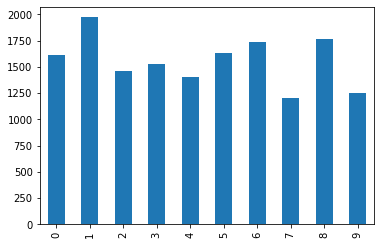

In [ ]:
train_df = pd.read_csv("/content/sf-dl-car-classification/train.csv")
train_df.Category.value_counts(sort=False).plot(kind="bar")

# #1. Наивная модель
**Модель**: Работаем мы с машинами, поэтому нашел вот такой датасет [Stanford Cars](http://ai.stanford.edu/~jkrause/cars/car_dataset.html) и [результат моделей по нему](https://paperswithcode.com/sota/image-classification-on-stanford-cars). Для наивной модели выбор пал на EffNetV2M:
- довольно хороший результат,
- не так много параметров,
- есть в keras. 

**Веса**: это вопрос, с которым я так и не разобрался: где добыть веса модели, обученной именно на этом датасете, в keras есть только imagenet веса (либо я не понял суть данного вопроса). В итоге взял imagenet.

**Голова**: возьму достаточно сложную структуру из примеров курса. Далее посмотрим в сравнении что лучше, простая или сложная голова.

**Заморозка слоев**: заморожу половину слоев базовой модели, без какого-либо обоснования, просто для референсной точки, потом в сравнении посмотрим на вариант обучения сразу всей модели, и постепенной разморозки.

**Аугментация**: особо мудроствовать не буду, возьму из примеров albumentations, может потом в поправлю.

**ТТА**: не использую.


In [9]:
# Генераторы изображений. rescale делать не буду, в модели есть
# include_preprocessing=True для этого. Аугментация только
# для тренировочных данных.
train_datagen = ImageDataGenerator(
    preprocessing_function=native_augment,
    validation_split=VAL_SPLIT,
)

val_datagen = ImageDataGenerator(
    validation_split=VAL_SPLIT,
)

sub_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=RANDOM_SEED,
    subset="training",
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=RANDOM_SEED,
    subset="validation",
)

sub_generator = sub_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Train:


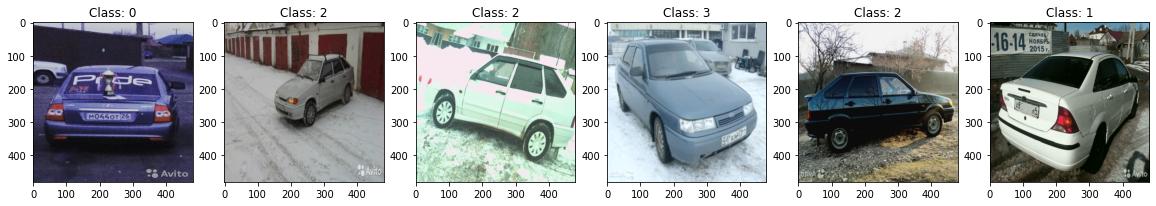

Val:


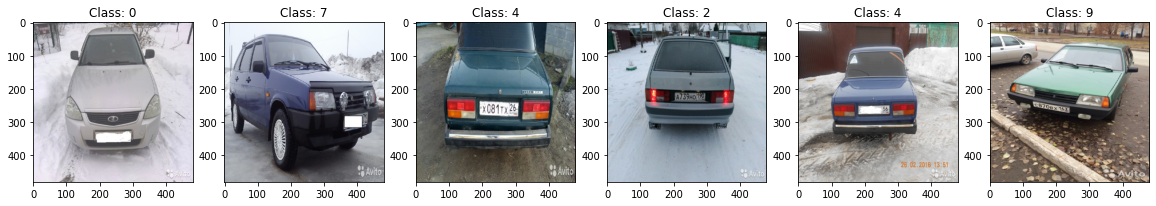

Sub:


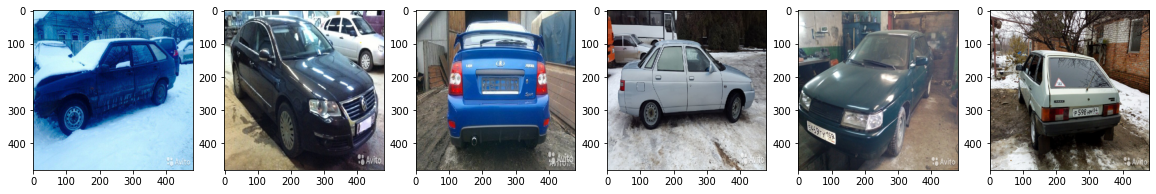

In [10]:
# Визуально посмотрим на картинки.
print("Train:")
show_first_images(train_generator)

print("Val:")
show_first_images(val_generator)

print("Sub:")
show_first_images(sub_generator, labels=False)

In [11]:
# Базовая модель
native_base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    include_preprocessing=True,
)

# Добавим голову
native_model = M.Sequential(
    [
        native_base_model,
        L.GlobalAveragePooling2D(),
        L.Dense(256, activation="relu"),
        L.BatchNormalization(),
        L.Dropout(0.25),
        L.Dense(len(class_names), activation="softmax"),
    ]
)

# Заморозим половину слоев
native_base_model.trainable = True
fine_tune_at = len(native_base_model.layers) // 2
for layer in native_base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Собираем модель
native_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=LR),
    metrics="accuracy",
)

214212608/214201816 [==============================] - 1s 0us/step


In [13]:
# Обучаем
native_history = native_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list,
)

# Загружаем лучшие веса
native_model.save(f"{drive_dir}/native_model_last.hdf5")
native_model.load_weights("best_model.hdf5")
native_model.save(f"{drive_dir}/native_model_best.hdf5")

Epoch 1/10
390/390 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.8652
Epoch 1: val_accuracy improved from -inf to 0.96044, saving model to best_model.hdf5
390/390 [==============================] - 806s 2s/step - loss: 0.4202 - accuracy: 0.8652 - val_loss: 0.1295 - val_accuracy: 0.9604 - lr: 4.0000e-04
Epoch 2/10
390/390 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9481
Epoch 2: val_accuracy did not improve from 0.96044
390/390 [==============================] - 762s 2s/step - loss: 0.1596 - accuracy: 0.9481 - val_loss: 0.1227 - val_accuracy: 0.9604 - lr: 4.0000e-04
Epoch 3/10
390/390 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9530
Epoch 3: val_accuracy improved from 0.96044 to 0.96333, saving model to best_model.hdf5
390/390 [==============================] - 765s 2s/step - loss: 0.1411 - accuracy: 0.9530 - val_loss: 0.1183 - val_accuracy: 0.9633 - lr: 4.0000e-04
Epoch 4/10
390/390 [=====================

In [14]:
# loss: 0.0295 - accuracy: 0.9896 - val_loss: 0.0827 - val_accuracy: 0.9794
# Сабмитим на kaggle: 0.97423
predictions = native_model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame(
    {"Id": sub_generator.filenames, "Category": predictions},
    columns=["Id", "Category"],
)
submission.to_csv(f"{drive_dir}/native_submission.csv", index=False)

209/209 [==============================] - 190s 887ms/step


In [16]:
# Очищаем ресурсы
cuda.select_device(0)
cuda.close()

# Обогащение датасета

In [18]:
# добавляем картинки
for class_id in class_ids:
    del_cnt = delete_augmented_image(train_path, class_id)
    print(f"class {class_id}: deleted {del_cnt} files")
    old_image_count, added_image_count = add_augmented_image(train_path, class_id, MAX_IMAGE_COUNT)
    print(
        f"class {class_id}: existed: {old_image_count}, added: {added_image_count},\
        total: {old_image_count+added_image_count}"
    )

class 0: deleted 1386 files
class 0: existed: 1613, added: 387,        total: 2000
class 1: deleted 1029 files
class 1: existed: 1971, added: 29,        total: 2000
class 2: deleted 0 files
class 2: existed: 1458, added: 542,        total: 2000
class 3: deleted 472 files
class 3: existed: 1528, added: 472,        total: 2000
class 4: deleted 600 files
class 4: existed: 1400, added: 600,        total: 2000
class 5: deleted 369 files
class 5: existed: 1631, added: 369,        total: 2000
class 6: deleted 267 files
class 6: existed: 1733, added: 267,        total: 2000
class 7: deleted 793 files
class 7: existed: 1207, added: 793,        total: 2000
class 8: deleted 235 files
class 8: existed: 1765, added: 235,        total: 2000
class 9: deleted 745 files
class 9: existed: 1255, added: 745,        total: 2000


# Генераторы и оценка картинок для новых моделей

In [23]:
# Генераторы изображений
train_datagen = ImageDataGenerator(
    preprocessing_function=model_augment,
    validation_split=VAL_SPLIT,
)

val_datagen = ImageDataGenerator(
    validation_split=VAL_SPLIT,
)

sub_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=RANDOM_SEED,
    subset="training",
)

val_generator = val_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=RANDOM_SEED,
    subset="validation",
)

sub_generator = sub_datagen.flow_from_dataframe(
    dataframe=pd.read_csv(sample_submission_path),
    directory=sub_path,
    x_col="Id",
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 24000 images belonging to 10 classes.
Found 6000 images belonging to 10 classes.
Found 6675 validated image filenames.


Train:


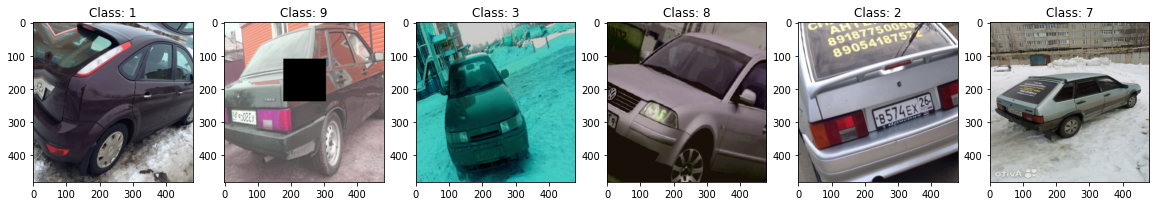

Val:


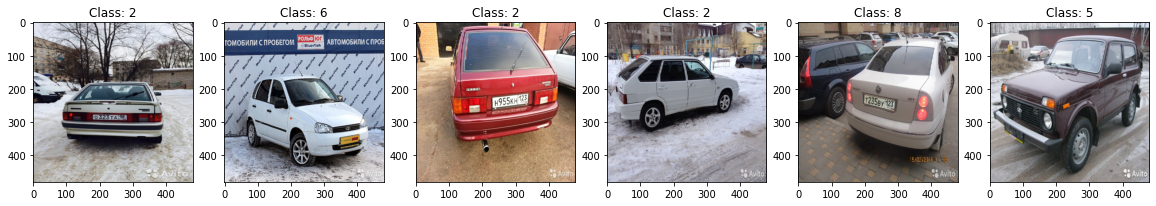

Sub:


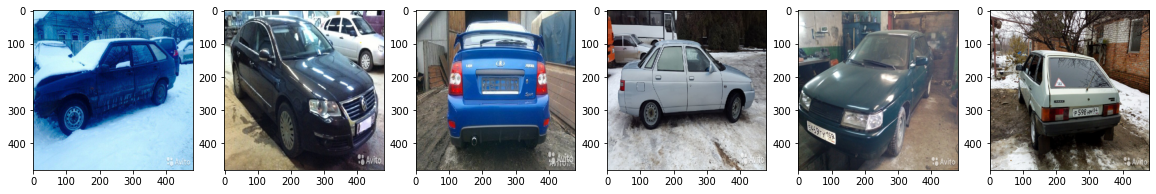

In [24]:
# Визуально посмотрим на картинки.
print("Train:")
show_first_images(train_generator)

print("Val:")
show_first_images(val_generator)

print("Sub:")
show_first_images(sub_generator, labels=False)

# #2. Модель с простой головой и заморозкой половины слоев

In [29]:
# Базовая модель
v1_base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    include_preprocessing=True,
)

# Добавим голову
v1_model = M.Sequential(
    [
        v1_base_model,
        L.GlobalAveragePooling2D(),
        L.Dense(len(class_names), activation="softmax"),
    ]
)

# Заморозим половину слоев
v1_base_model.trainable = True
fine_tune_at = len(v1_base_model.layers) // 2
for layer in v1_base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Собираем модель
v1_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=LR),
    metrics="accuracy",
)

In [11]:
# Обучаем
v1_history = v1_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list,
)

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8830
Epoch 1: val_accuracy improved from -inf to 0.96275, saving model to best_model.hdf5
500/500 [==============================] - 1025s 2s/step - loss: 0.3377 - accuracy: 0.8830 - val_loss: 0.1128 - val_accuracy: 0.9628 - lr: 4.0000e-04
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9446
Epoch 2: val_accuracy improved from 0.96275 to 0.96600, saving model to best_model.hdf5
500/500 [==============================] - 987s 2s/step - loss: 0.1492 - accuracy: 0.9446 - val_loss: 0.1028 - val_accuracy: 0.9660 - lr: 4.0000e-04
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9508
Epoch 3: val_accuracy did not improve from 0.96600
500/500 [==============================] - 982s 2s/step - loss: 0.1293 - accuracy: 0.9508 - val_loss: 0.1044 - val_accuracy: 0.9653 - lr: 4.0000e-04
Epoch 4/10
500/500 [====================

In [11]:
# Загружаем лучшие веса
v1_model.save(f"{drive_dir}/v1_model_last.hdf5")
v1_model.load_weights("best_model.hdf5")
v1_model.save(f"{drive_dir}/v1_model_best.hdf5")

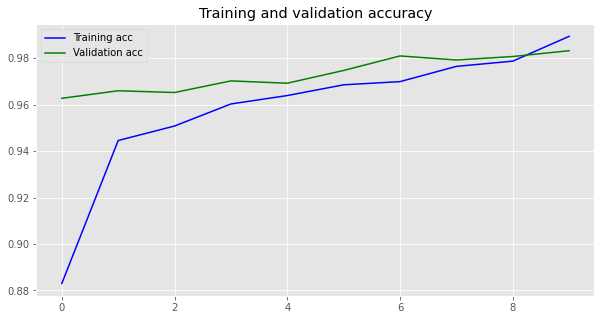

In [19]:
# кажется есть небольшое переобучение после 8 эпохи, с другой стороны val_acc
# все еще растет, можно попробовать увеличить число эпох
plot_history(v1_history)

In [20]:
# loss: 0.0318 - accuracy: 0.9894 - val_loss: 0.0706 - val_accuracy: 0.9833 - lr: 1.0000e-04
# Сабмитим на kaggle: 0.97872

predictions = v1_model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame(
    {"Id": sub_generator.filenames, "Category": predictions},
    columns=["Id", "Category"],
)
submission.to_csv(f"{drive_dir}/v1_submission.csv", index=False)

835/835 [==============================] - 217s 252ms/step


In [21]:
# Очищаем ресурсы
cuda.select_device(0)
cuda.close()

# #3. Добавим TTA

Found 6675 validated image filenames.


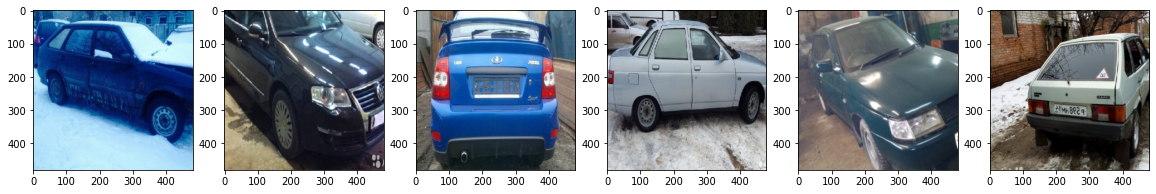

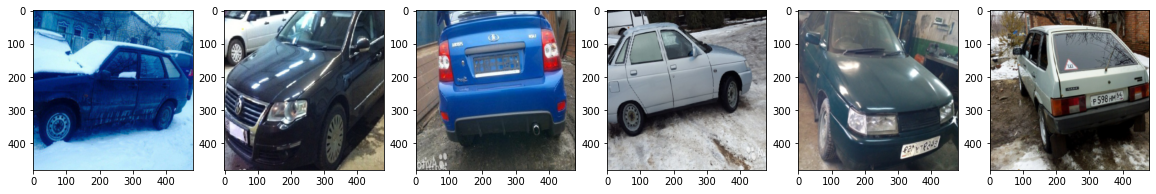

209/209 [==============================] - 98s 466ms/step


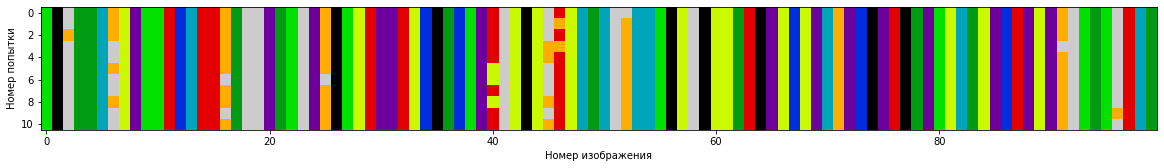

In [31]:
submission = add_tta(v1_model)

In [25]:
# Сабмитим на kaggle: 0.97857 - получилось чуть хуже, чем без TTA
# судя по очень близкому числу есть несколько картинок,
# которые прыгают между классами
submission.to_csv(f"{drive_dir}/v1_tta_submission.csv", index=False)

# #4. Модель с простой головой без заморозки слоев

In [17]:
# уменьшим batch_size так как без заморозки слоев не влезает в GPU RAM
train_generator.batch_size = BATCH_SIZE // 4
val_generator.batch_size = BATCH_SIZE // 4
sub_generator.batch_size = BATCH_SIZE // 4

In [ ]:
# Базовая модель
v2_base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    include_preprocessing=True,
)

# Добавим голову
v2_model = M.Sequential(
    [
        v2_base_model,
        L.GlobalAveragePooling2D(),
        L.Dense(len(class_names), activation="softmax"),
    ]
)

# Собираем модель
v2_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=LR),
    metrics="accuracy",
)

In [8]:
# Обучаем
v2_history = v2_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list,
)

Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.7869
Epoch 1: val_accuracy improved from -inf to 0.94799, saving model to best_model.hdf5
2000/2000 [==============================] - 1159s 561ms/step - loss: 0.6060 - accuracy: 0.7869 - val_loss: 0.1564 - val_accuracy: 0.9480 - lr: 4.0000e-04
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.8839
Epoch 2: val_accuracy improved from 0.94799 to 0.95024, saving model to best_model.hdf5
2000/2000 [==============================] - 1112s 556ms/step - loss: 0.3188 - accuracy: 0.8839 - val_loss: 0.1391 - val_accuracy: 0.9502 - lr: 4.0000e-04
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9047
Epoch 3: val_accuracy did not improve from 0.95024
2000/2000 [==============================] - 1108s 554ms/step - loss: 0.2619 - accuracy: 0.9047 - val_loss: 0.1789 - val_accuracy: 0.9430 - lr: 4.0000e-04
Epoch 4/10
2000/2

In [ ]:
# Загружаем лучшие веса
v2_model.save(f"{drive_dir}/v2_model_last.hdf5")
v2_model.load_weights("best_model.hdf5")
v2_model.save(f"{drive_dir}/v2_model_best.hdf5")

In [22]:
# Сабмитим на kaggle: 0.97602, хуже чем v1 без TTA.
predictions = v2_model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame(
    {"Id": sub_generator.filenames, "Category": predictions},
    columns=["Id", "Category"],
)
submission.to_csv(f"{drive_dir}/v2_submission.csv", index=False)

835/835 [==============================] - 125s 135ms/step


# #5. Добавим TTA

Found 6675 validated image filenames.


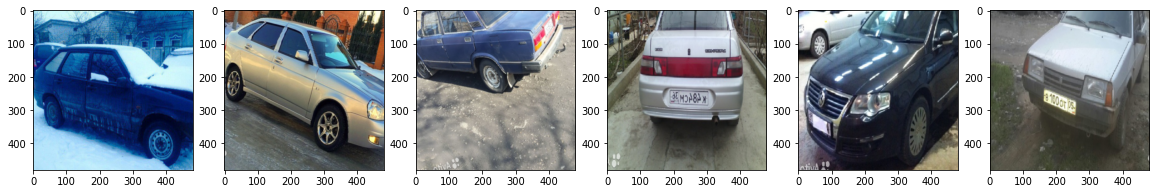

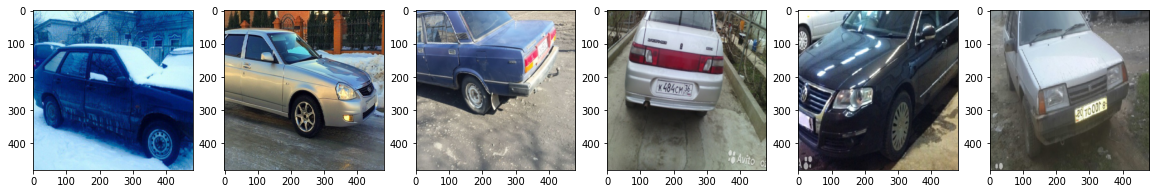

835/835 [==============================] - 113s 135ms/step


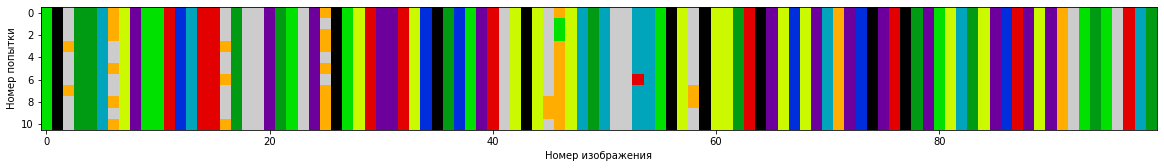

In [28]:
submission = add_tta(v2_model, BATCH_SIZE//4)

In [ ]:
# 0.97662,опять чуть меньше ранее полученного результата
submission.to_csv(f"{drive_dir}/v2_tta_submission.csv", index=False)

# #6. Модель с простой головой с постепенной разморозкой

In [17]:
# Базовая модель
v3_base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    include_preprocessing=True,
)

# Добавим голову
v3_model = M.Sequential(
    [
        v3_base_model,
        L.GlobalAveragePooling2D(),
        L.Dense(len(class_names), activation="softmax"),
    ]
)

# Заморозим загруженную модель
v3_base_model.trainable = False

# Собираем модель
v3_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=LR),
    metrics="accuracy",
)

In [18]:
# Обучаем
v3_history = v3_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list,
)

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 1.7010 - accuracy: 0.4298
Epoch 1: val_accuracy did not improve from 0.78620
500/500 [==============================] - 511s 989ms/step - loss: 1.7010 - accuracy: 0.4298 - val_loss: 1.4009 - val_accuracy: 0.5196 - lr: 4.0000e-04
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 1.3667 - accuracy: 0.5446
Epoch 2: val_accuracy did not improve from 0.78620
500/500 [==============================] - 500s 1s/step - loss: 1.3667 - accuracy: 0.5446 - val_loss: 1.2168 - val_accuracy: 0.5949 - lr: 4.0000e-04
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 1.2353 - accuracy: 0.5919
Epoch 3: val_accuracy did not improve from 0.78620
500/500 [==============================] - 499s 997ms/step - loss: 1.2353 - accuracy: 0.5919 - val_loss: 1.1145 - val_accuracy: 0.6322 - lr: 4.0000e-04
Epoch 4/10
500/500 [==============================] - ETA: 0s - loss: 1.1542 - accuracy: 0.6258
Epoch 4: v

In [19]:
# Загружаем лучшие веса
v3_model.save(f"{drive_dir}/v3_step1_model_last.hdf5")
v3_model.load_weights("best_model.hdf5")
v3_model.save(f"{drive_dir}/v3_step1_model_best.hdf5")

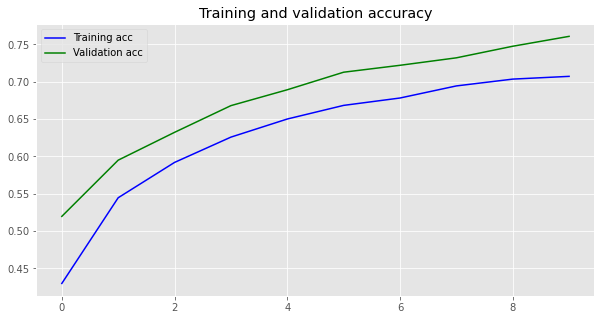

In [22]:
# эпох побольше нужно сделать, или LR увеличить
plot_history(v3_history)

In [20]:
# разморозим половину слоев
v3_base_model.trainable = True
fine_tune_at = len(v3_base_model.layers)//2
for layer in v3_base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# Собираем модель
v3_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=LR),
    metrics="accuracy",
)

In [23]:
# и обучим
v3_history = v3_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list,
)

Epoch 1/10
500/500 [==============================] - ETA: 0s - loss: 0.2996 - accuracy: 0.8934
Epoch 1: val_accuracy improved from 0.78620 to 0.96274, saving model to best_model.hdf5
500/500 [==============================] - 593s 1s/step - loss: 0.2996 - accuracy: 0.8934 - val_loss: 0.1225 - val_accuracy: 0.9627 - lr: 4.0000e-04
Epoch 2/10
500/500 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9469
Epoch 2: val_accuracy improved from 0.96274 to 0.96424, saving model to best_model.hdf5
500/500 [==============================] - 565s 1s/step - loss: 0.1435 - accuracy: 0.9469 - val_loss: 0.1153 - val_accuracy: 0.9642 - lr: 4.0000e-04
Epoch 3/10
500/500 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9567
Epoch 3: val_accuracy improved from 0.96424 to 0.97349, saving model to best_model.hdf5
500/500 [==============================] - 566s 1s/step - loss: 0.1154 - accuracy: 0.9567 - val_loss: 0.0981 - val_accuracy: 0.9735 - lr: 4.0000e-04
E

In [24]:
# Загружаем лучшие веса
v3_model.save(f"{drive_dir}/v3_step2_model_last.hdf5")
v3_model.load_weights("best_model.hdf5")
v3_model.save(f"{drive_dir}/v3_step2_model_best.hdf5")

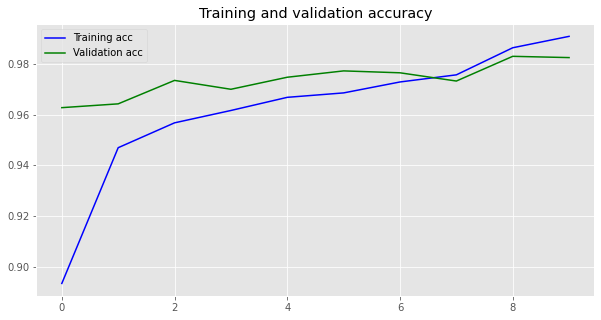

In [25]:
plot_history(v3_history)

In [28]:
# уменьшим batch_size так как не влезает в GPU RAM
train_generator.batch_size = BATCH_SIZE // 2
val_generator.batch_size = BATCH_SIZE // 2
sub_generator.batch_size = BATCH_SIZE // 2

# разморозим 3/4 слоев
v3_base_model.trainable = True
fine_tune_at = len(v3_base_model.layers)//4
for layer in v3_base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# Собираем модель
v3_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=LR),
    metrics="accuracy",
)

In [29]:
# и обучим
v3_history = v3_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_list,
)

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1634 - accuracy: 0.9414
Epoch 1: val_accuracy did not improve from 0.98300
1000/1000 [==============================] - 788s 764ms/step - loss: 0.1634 - accuracy: 0.9414 - val_loss: 0.1227 - val_accuracy: 0.9635 - lr: 4.0000e-04
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.9521
Epoch 2: val_accuracy did not improve from 0.98300
1000/1000 [==============================] - 759s 758ms/step - loss: 0.1326 - accuracy: 0.9521 - val_loss: 0.0986 - val_accuracy: 0.9737 - lr: 4.0000e-04
Epoch 3/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1141 - accuracy: 0.9596
Epoch 3: val_accuracy did not improve from 0.98300
1000/1000 [==============================] - 758s 758ms/step - loss: 0.1141 - accuracy: 0.9596 - val_loss: 0.1096 - val_accuracy: 0.9695 - lr: 4.0000e-04
Epoch 4/10
1000/1000 [==============================] - ETA: 0s - loss: 0.1095 - accuracy: 

In [30]:
# Загружаем лучшие веса
v3_model.save(f"{drive_dir}/v3_step3_model_last.hdf5")
v3_model.load_weights("best_model.hdf5")
v3_model.save(f"{drive_dir}/v3_step3_model_best.hdf5")

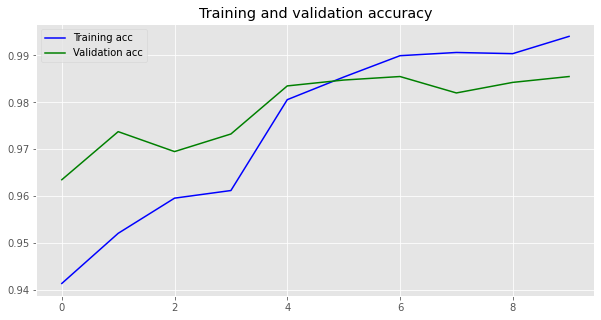

In [31]:
plot_history(v3_history)

In [32]:
# Сабмитим на kaggle: 0.97677
# В целом результат примерно тот же самый, но времени занимает гораздо больше
predictions = v3_model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame(
    {"Id": sub_generator.filenames, "Category": predictions},
    columns=["Id", "Category"],
)
submission.to_csv(f"{drive_dir}/v3_submission.csv", index=False)

418/418 [==============================] - 104s 240ms/step


# #7. Увеличим число эпох

In [19]:
# лучший вариант дала модель с простой головой и заморозкой половины слоев
# возьмем ту же модель, только увеличим число эпох, увеличим число картинок
# до 3000 на класс, все остальное без изменений

# добавляем картинки поверх уже созданных
for class_id in class_ids:
    old_image_count, added_image_count = add_augmented_image(
        train_path,
        class_id,
        MAX_IMAGE_COUNT+1000,
    )
    print(
        f"class {class_id}: existed: {old_image_count}, added: {added_image_count},\
        total: {old_image_count+added_image_count}"
    )

class 0: existed: 2000, added: 1000,        total: 3000
class 1: existed: 2000, added: 1000,        total: 3000
class 2: existed: 2000, added: 1000,        total: 3000
class 3: existed: 2000, added: 1000,        total: 3000
class 4: existed: 2000, added: 1000,        total: 3000
class 5: existed: 2000, added: 1000,        total: 3000
class 6: existed: 2000, added: 1000,        total: 3000
class 7: existed: 2000, added: 1000,        total: 3000
class 8: existed: 2000, added: 1000,        total: 3000
class 9: existed: 2000, added: 1000,        total: 3000


In [20]:
# Базовая модель
v4_base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    include_preprocessing=True,
)

# Добавим голову
v4_model = M.Sequential(
    [
        v4_base_model,
        L.GlobalAveragePooling2D(),
        L.Dense(len(class_names), activation="softmax"),
    ]
)

# Заморозим половину слоев
v4_base_model.trainable = True
fine_tune_at = len(v4_base_model.layers) // 2
for layer in v4_base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Собираем модель
v4_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=LR),
    metrics="accuracy",
)

214212608/214201816 [==============================] - 2s 0us/step


In [26]:
# Обучаем
v4_history = v4_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS+5,
    callbacks=callbacks_list,
)

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 0.3036 - accuracy: 0.8922
Epoch 1: val_accuracy improved from -inf to 0.96317, saving model to best_model.hdf5
750/750 [==============================] - 975s 1s/step - loss: 0.3036 - accuracy: 0.8922 - val_loss: 0.1042 - val_accuracy: 0.9632 - lr: 4.0000e-04
Epoch 2/15
750/750 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9446
Epoch 2: val_accuracy improved from 0.96317 to 0.97133, saving model to best_model.hdf5
750/750 [==============================] - 920s 1s/step - loss: 0.1485 - accuracy: 0.9446 - val_loss: 0.0777 - val_accuracy: 0.9713 - lr: 4.0000e-04
Epoch 3/15
750/750 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9560
Epoch 3: val_accuracy improved from 0.97133 to 0.97450, saving model to best_model.hdf5
750/750 [==============================] - 908s 1s/step - loss: 0.1143 - accuracy: 0.9560 - val_loss: 0.0769 - val_accuracy: 0.9745 - lr: 4.0000e-04
Epoc

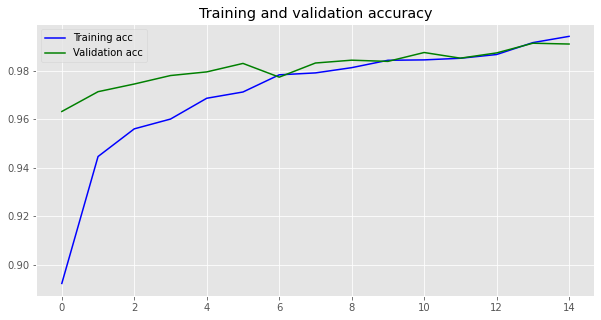

In [27]:
plot_history(v4_history)

In [28]:
# Загружаем лучшие веса
v4_model.save(f"{drive_dir}/v4_model_last.hdf5")
v4_model.load_weights("best_model.hdf5")
v4_model.save(f"{drive_dir}/v4_model_best.hdf5")

In [29]:
# loss: 0.0253 - accuracy: 0.9916 - val_loss: 0.0361 - val_accuracy: 0.9913 - lr: 1.0000e-04
# kaggle 0.97498
predictions = v4_model.predict(sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame(
    {"Id": sub_generator.filenames, "Category": predictions},
    columns=["Id", "Category"],
)
submission.to_csv(f"{drive_dir}/v4_submission.csv", index=False)

209/209 [==============================] - 114s 474ms/step
